# TF_IDF

In [1]:
%config IPCompleter.greedy=True

## 1. Import packages

In [2]:
import numpy as np  
import pandas as pd 
## nltk
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
## sklearn
from sklearn.metrics import average_precision_score, accuracy_score ## not used
from sklearn.model_selection import GridSearchCV ## not used
from sklearn.model_selection import train_test_split ## not used
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score
## classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
## matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/Users/inescamara/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2. Data

In [3]:
train = pd.read_csv('./emails.train.csv')
text = train['text']
# ham_count = train[train['spam']==0]
# spam_count = train[train['spam']==1]

## 3. Define Methods for Text Processing 

In [4]:
re_tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # tokenize words that are not numbers
mystopwords = set(stopwords.words('english')) # stop words remover
extras = set(['_', 'subject']) # remove subject and _
mystopwords.update(extras)
ps = PorterStemmer() # stemming words --> method not used
stemmer = SnowballStemmer("english") # stemming words 
lemmatizer = WordNetLemmatizer() # lemmatizing words --> method not used

## 4. Perform Text Processing

In [5]:
## First, stem and create list of words
def stemm(df):
    for i, line in enumerate(df['text']): 
        newline = [] 
        words = line.split() 
        for word in words: 
            word = stemmer.stem(word) 
            #word = lemmatizer.lemmatize(word)
            #word = ps.stem(word)
            newline.append(word)
        new = ' '.join(newline)  
        df.loc[i, 'text'] = new # replace line at the index position with the new line that is the stemmed words



In [6]:
## dirty data
train = pd.read_csv('./emails.train.csv')
test  = pd.read_csv('./emails.test.csv')

## clean data
stemm(train)
stemm(test)


### We tried train_test_split but decided to go for cross-validation instead
#subtrain_X, subval_X = train_test_split(train, test_size = 0.25)

Y_train = train['spam'] ## labels
Y_test = test['spam'] ## labels

## 5. TF_IDF Feature Extraction

In [7]:
vectorizer = TfidfVectorizer(stop_words=mystopwords, tokenizer=re_tokenizer.tokenize, max_features = 2000)
v = vectorizer.fit(train['text'])

X_train = v.transform(train['text']).todense() ## features
X_test = v.transform(test['text']).todense() ## features
print(X_train)


[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.11628906 ...,  0.          0.          0.        ]]


## 6. Model Evaluation

### Create Empty Arrays to Use for Plotting Evaluation Results

In [8]:
method_name = []
accuracy_value = []

### Model 1: KNN Classifier

#### GridSearch to select hyperparameter 

In [9]:
# ## We first tried GridSearch to look for the best hyperparameter, but decided to go for cross-validation

# knn = KNeighborsClassifier()
# params = {
#     'n_neighbors': [1, 2, 5],
#     'p': [1, 2]
# }

# grid_search = GridSearchCV(knn,params,n_jobs=-1) ## -1 is faster

# grid_search.fit(X_train, Y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

# estimator = grid_search.best_estimator_ 
# Y_pred = estimator.predict(X_test)

#### Cross-validation to select hyperparameter

In [10]:
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.94454142780894501, 0.89754677045765641, 0.91096232912527508, 0.89180432589501402, 0.97214911500922518, 0.96120380443407727, 0.97363484397902467, 0.96741838907909039, 0.97089789907414858, 0.9684121886683611]


#### Plot results accuracy scores

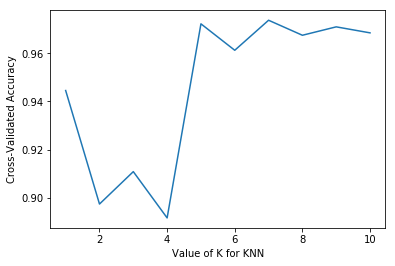

In [11]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig("neighbors.svg", format="svg")
plt.show()

#### With higest accuracy parameter, perform cross-validation for model selection

In [12]:
knn = KNeighborsClassifier(n_neighbors=7) 
scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy').mean()
print(scores)

0.973634843979


#### Store method name and average accuracy on variables

In [13]:
method_name.append('KNN')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN']
[0.97363484397902467]


### Model 2: Decision Tree

#### Perform cross-validation for model selection

In [14]:
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, X_train, Y_train, cv = 10, scoring = 'accuracy').mean()
print(scores)

0.951254774807


#### Store method name and average accuracy on variables

In [15]:
method_name.append('DecisionTree')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree']
[0.97363484397902467, 0.95125477480699205]


### Model 3: Random Forest Classifier

#### Cross-validation to select hyperparameter

In [16]:
rforest = RandomForestClassifier()
k_range = range(11, 51)
k_scores = []
for k in k_range:
    rforest = RandomForestClassifier(n_estimators= k)
    scores = cross_val_score(rforest, X_train, Y_train, cv = 10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)


[0.97711929514140416, 0.96767892251643173, 0.97140532771130095, 0.97264600710733817, 0.97339290533957945, 0.97289662742394667, 0.97737424860007194, 0.97363980053939092, 0.97711869943057739, 0.97786682602777897, 0.9788606040667871, 0.97438607535332511, 0.97637984406414802, 0.97786743405304133, 0.97811619950777362, 0.97687797376304819, 0.97861308852727757, 0.97712487819868632, 0.98209877729044415, 0.976377986123663, 0.97836866852904036, 0.97936306690774644, 0.97936554518792962, 0.97761868091274484, 0.98134817857027756, 0.97861556988606968, 0.98135003343215355, 0.97812114375370418, 0.98109880816889183, 0.98035314445882871, 0.98159755205027199, 0.97960996518616672, 0.98135312589481694, 0.98110374625760455, 0.97960626161963216, 0.98010377405744309, 0.97885999604152474, 0.97662798302196452, 0.9803519160938684, 0.98085252407295154]


#### Plot results accuracy scores

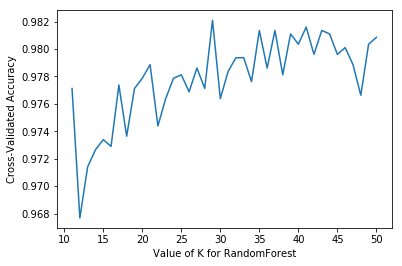

In [17]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for RandomForest')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig("estimators.svg", format="svg")
plt.show()

#### With higest accuracy parameter, perform cross-validation for model selection

In [18]:
rforest = RandomForestClassifier(n_estimators=37)
scores = cross_val_score(rforest, X_train, Y_train, cv = 10, scoring = 'accuracy').mean()
print(scores)

0.978613708867


#### Store method name and average accuracy on variables

In [19]:
method_name.append('RandomForest')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree', 'RandomForest']
[0.97363484397902467, 0.95125477480699205, 0.97861370886697563]


### Model 4: SVM 

#### Perform cross-validation for model selection

In [20]:
svm = SVC()
scores = cross_val_score(svm, X_train, Y_train, cv = 10, scoring = 'accuracy').mean()
print(scores)

0.762995230034


#### Store method name and average accuracy on variables

In [21]:
method_name.append('SVM')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree', 'RandomForest', 'SVM']
[0.97363484397902467, 0.95125477480699205, 0.97861370886697563, 0.76299523003412051]


### Model 5: Multinomial Naive Bayes

#### Perform cross-validation for model selection

In [22]:
nb = MultinomialNB()
scores = cross_val_score(nb, X_train, Y_train, cv = 10, scoring = 'accuracy').mean()
print(scores)

0.984082651352


#### Store method name and average accuracy on variables

In [23]:
method_name.append('NaiveBayes')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree', 'RandomForest', 'SVM', 'NaiveBayes']
[0.97363484397902467, 0.95125477480699205, 0.97861370886697563, 0.76299523003412051, 0.98408265135218809]


### Model 6: Logistic Regression

#### Perform cross-validation for model selection

In [24]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_train, Y_train, cv=10, scoring='accuracy').mean()
print(scores)

0.982341351663


#### Store method name and average accuracy on variables

In [25]:
method_name.append('LogisticRegression')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree', 'RandomForest', 'SVM', 'NaiveBayes', 'LogisticRegression']
[0.97363484397902467, 0.95125477480699205, 0.97861370886697563, 0.76299523003412051, 0.98408265135218809, 0.98234135166263203]


### Model 7: Gaussian Process Classifier 

#### Perform cross-validation for model selection

In [26]:
gp = GaussianProcessClassifier()
scores = cross_val_score(gp, X_train, Y_train, cv=10, scoring='accuracy').mean()
print(scores)

0.969412790444


#### Store method name and average accuracy on variables

In [27]:
method_name.append('GaussianProcess')
accuracy_value.append(scores)
print(method_name)
print(accuracy_value)

['KNN', 'DecisionTree', 'RandomForest', 'SVM', 'NaiveBayes', 'LogisticRegression', 'GaussianProcess']
[0.97363484397902467, 0.95125477480699205, 0.97861370886697563, 0.76299523003412051, 0.98408265135218809, 0.98234135166263203, 0.96941279044404727]


### Plot evaluation results

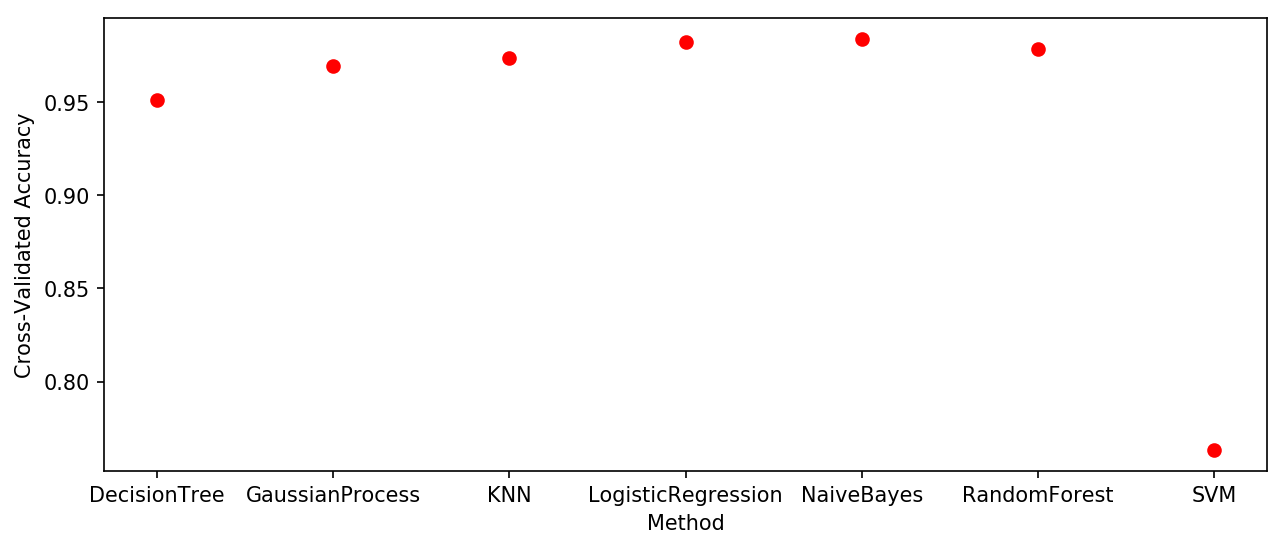

In [28]:
fig = plt.figure(figsize=(10, 4), dpi=150)

plt.plot(method_name, accuracy_value, 'ro')
plt.xlabel('Method')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig("accuracy.svg", format="svg")
plt.show()

## 7. Predictions

In [29]:
nb = MultinomialNB()

nb.fit(X_train, Y_train)

Y_pred = nb.predict(X_test)

print(accuracy_score(Y_test, Y_pred))



0.97539543058


#### Write to csv solution

In [30]:
pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('predictions.nb.csv', index=False)